In [1]:
import numpy as np
import pandas as pd
import os
import torch
import pickle
from tqdm.notebook import tqdm

In [3]:
# --- Define Kaggle Paths ---
# Verify the competition slug is correct in the input path
COMPETITION_SLUG = 'birdclef-2025'
BASE_INPUT_PATH = os.path.join('/kaggle/input', COMPETITION_SLUG)
TRAIN_CSV_PATH = os.path.join(BASE_INPUT_PATH, 'train.csv')
TRAIN_AUDIO_DIR = os.path.join(BASE_INPUT_PATH, 'train_audio/')

# Kaggle's writable directory for output
OUTPUT_DIR = '/kaggle/working/'
OUTPUT_PKL_PATH = os.path.join(OUTPUT_DIR, 'train_audio_speech_timestamps.pkl')
# --- End Path Definitions ---

print(f"Train CSV Path: {TRAIN_CSV_PATH}")
print(f"Train Audio Directory: {TRAIN_AUDIO_DIR}")
print(f"Output Pickle Path: {OUTPUT_PKL_PATH}")

# Check if input paths exist (sanity check)
print(f"\nTrain CSV exists: {os.path.exists(TRAIN_CSV_PATH)}")
print(f"Train Audio directory exists: {os.path.exists(TRAIN_AUDIO_DIR)}")

# Ensure the output directory exists (it should by default)
os.makedirs(OUTPUT_DIR, exist_ok=True)

Train CSV Path: /kaggle/input/birdclef-2025/train.csv
Train Audio Directory: /kaggle/input/birdclef-2025/train_audio/
Output Pickle Path: /kaggle/working/train_audio_speech_timestamps.pkl

Train CSV exists: True
Train Audio directory exists: True


In [4]:
# --- Device Setup ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if device.type == 'cuda':
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")

# --- Load Silero VAD Model ---
model = None # Initialize
utils = None # Initialize
print("Loading Silero VAD model (requires internet for first download)...")
# Use force_reload=False after the first download
model, utils = torch.hub.load(repo_or_dir='snakers4/silero-vad',
                              model='silero_vad',
                              force_reload=False,
                              onnx=False, # Use PyTorch version
                              trust_repo=True) # Add if required by torch version
(get_speech_timestamps, _, read_audio, _, _) = utils

model.to(device) 
print("Silero VAD model loaded successfully.")



Using device: cpu
Loading Silero VAD model (requires internet for first download)...


Downloading: "https://github.com/snakers4/silero-vad/zipball/master" to /root/.cache/torch/hub/master.zip


Silero VAD model loaded successfully.


In [5]:
# --- Load Train Metadata ---
train_df = None # Initialize
if os.path.exists(TRAIN_CSV_PATH):
    try:
        train_df = pd.read_csv(TRAIN_CSV_PATH)
        print(f"Loaded train metadata with {len(train_df)} entries.")
        # Optional: Use a subset for quick testing
        # train_df = train_df.head(100).copy()
        # print(f"Using subset of {len(train_df)} entries for testing.")
    except Exception as e:
        print(f"Error loading {TRAIN_CSV_PATH}: {e}")
else:
    print(f"ERROR: Train CSV not found at {TRAIN_CSV_PATH}. Cannot proceed.")

Loaded train metadata with 28564 entries.


In [6]:

train_df_deduplicated = None # Initialize variable for the deduplicated DataFrame

if train_df is not None:
    print("\n--- Checking for Metadata Duplicates ---")
    original_rows = len(train_df)
    print(f"Original number of rows in train_df: {original_rows}")

    # Define columns to identify potential duplicate recordings
    # Common choices, adjust if you have better criteria
    duplicate_check_cols = ['primary_label', 'latitude', 'longitude', 'author']
    print(f"Checking for duplicates based on columns: {duplicate_check_cols}")

    # Verify that all specified columns actually exist in the DataFrame
    if all(col in train_df.columns for col in duplicate_check_cols):

        # Create a temporary copy for checking duplicates, handling potential NaNs
        temp_df_for_dup_check = train_df[duplicate_check_cols].copy()
        for col in duplicate_check_cols:
            if temp_df_for_dup_check[col].isnull().any():
                # Fill NaNs appropriately based on column type to allow duplication check
                if pd.api.types.is_numeric_dtype(temp_df_for_dup_check[col]):
                    temp_df_for_dup_check[col] = temp_df_for_dup_check[col].fillna(-9999) # Or another suitable numeric placeholder
                else:
                    temp_df_for_dup_check[col] = temp_df_for_dup_check[col].fillna('__MISSING__') # String placeholder

        duplicates_mask = temp_df_for_dup_check.duplicated(keep='first')
        num_duplicates = duplicates_mask.sum()
        print(f"Number of potential duplicate rows identified: {num_duplicates}")

        if num_duplicates > 0:
            train_df_deduplicated = train_df[~duplicates_mask].copy()
            print(f"Number of rows after removing duplicates: {len(train_df_deduplicated)}")
        else:
            print("No metadata duplicates found based on selected columns.")
            train_df_deduplicated = train_df.copy() # No duplicates found, use the original df

    else:
        missing_cols = [col for col in duplicate_check_cols if col not in train_df.columns]
        print(f"Warning: Cannot check duplicates. Columns not found: {missing_cols}")
        print("Proceeding without deduplication.")
        train_df_deduplicated = train_df.copy() # Use original if columns are missing

else:
    print("Skipping duplicate check: train_df was not loaded.")


--- Checking for Metadata Duplicates ---
Original number of rows in train_df: 28564
Checking for duplicates based on columns: ['primary_label', 'latitude', 'longitude', 'author']
Number of potential duplicate rows identified: 7119
Number of rows after removing duplicates: 21445


In [7]:
train_df = train_df_deduplicated

In [8]:
TAXON_CSV_PATH = os.path.join(BASE_INPUT_PATH, 'taxonomy.csv')
taxonomy_df = pd.read_csv(TAXON_CSV_PATH)

In [9]:
bird_audio_df = pd.DataFrame()

if taxonomy_df is not None and train_df is not None:
    if 'primary_label' in taxonomy_df.columns and 'primary_label' in train_df.columns:
        # use a left merge to keep all rows from train_df
        merged_df = pd.merge(train_df, taxonomy_df[['primary_label', 'class_name']], on='primary_label', how='left')

        # Filter for rows where class_name is 'Aves'
        bird_audio_df = merged_df[merged_df['class_name'] == 'Aves'].copy()
        
        num_total_files = len(merged_df)
        num_bird_files = len(bird_audio_df)
        print(f"Filtered for bird species ('Aves'): {num_bird_files} files out of {num_total_files} will be processed for speech.")

        if num_bird_files == 0 and num_total_files > 0:
            print("Warning: No bird species files found after filtering. Check 'Aves' spelling and taxonomy data.")

Filtered for bird species ('Aves'): 20761 files out of 21445 will be processed for speech.


## Class distribution

Analyzing deduplicated data.

--- Analyzing Class Distribution in train_df_deduplicated ---
Total number of unique classes (species): 206
Total number of samples analyzed: 21445

--- Top 10 Most Frequent Classes ---
primary_label
grekis     799
compau     631
trokin     596
roahaw     551
whtdov     467
banana     450
soulap1    409
bobfly1    402
socfly1    394
yeofly1    387
Name: count, dtype: int64

--- Bottom 10 Least Frequent Classes ---
primary_label
1462711    2
868458     1
523060     1
1564122    1
715170     1
714022     1
528041     1
66016      1
548639     1
1139490    1
Name: count, dtype: int64

--- Distribution Statistics (Counts per class) ---
count    206.000000
mean     104.101942
std      130.614474
min        1.000000
25%       13.250000
50%       60.000000
75%      139.000000
max      799.000000
Name: count, dtype: float64

--- Plotting Class Distribution (Top 50) ---


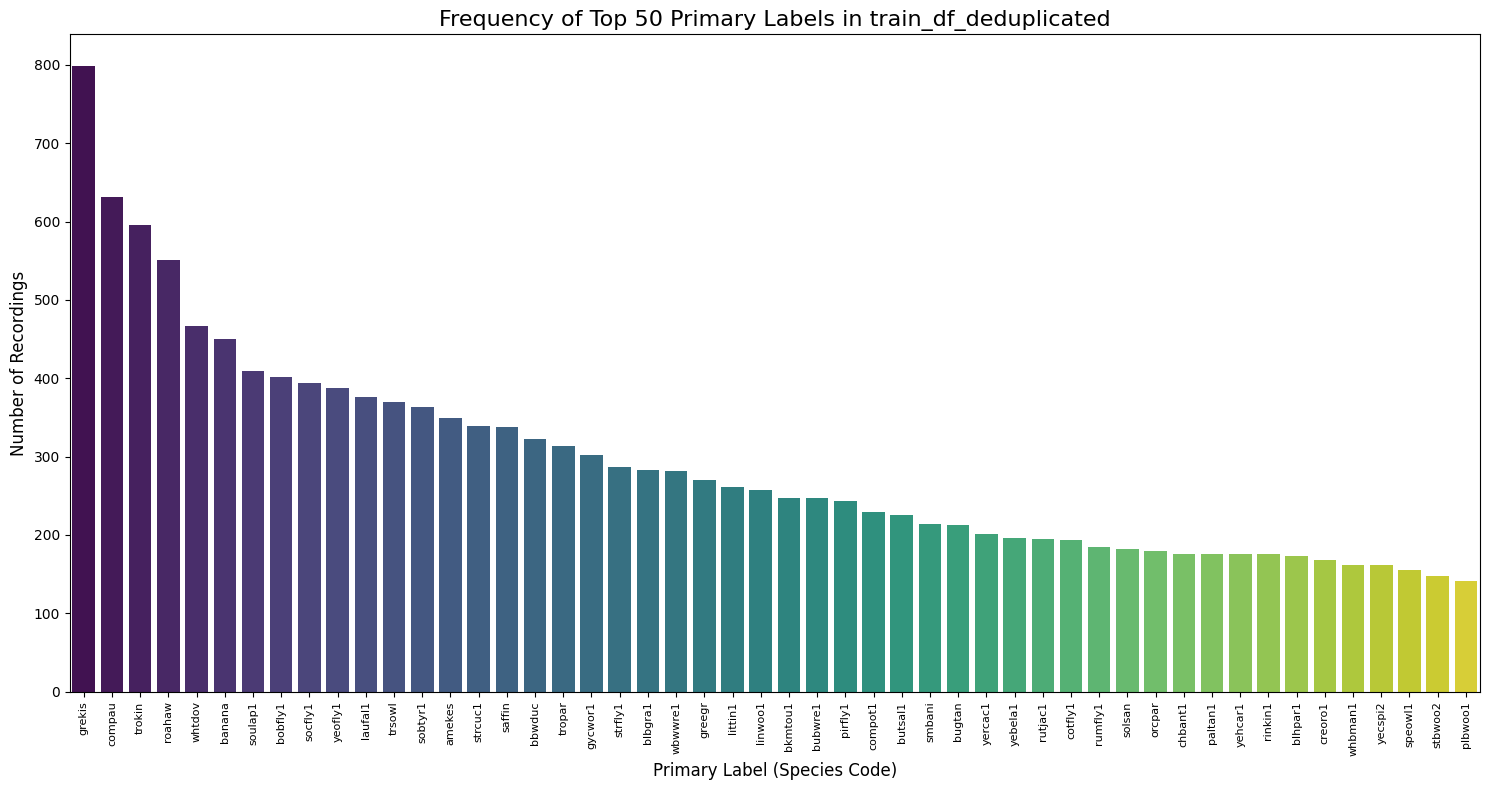

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Select DataFrame to Analyze ---
# Preferably use the deduplicated dataframe if it exists and is not None
df_to_analyze = None
df_name = ""
if 'train_df_deduplicated' in locals() and train_df_deduplicated is not None:
    df_to_analyze = train_df_deduplicated
    df_name = "train_df_deduplicated"
    print("Analyzing deduplicated data.")
elif 'train_df' in locals() and train_df is not None:
    # Fallback to original if deduplicated version doesn't exist/wasn't run
    df_to_analyze = train_df
    df_name = "train_df"
    print("Analyzing original train_df (deduplicated version not found/available).")
else:
     print("Cannot analyze class imbalance: DataFrame not loaded.")

# --- Perform Analysis if DataFrame is available ---
if df_to_analyze is not None:
    # Check if the primary_label column exists
    if 'primary_label' in df_to_analyze.columns:
        print(f"\n--- Analyzing Class Distribution in {df_name} ---")

        # Get the counts for each unique value in 'primary_label'
        # This series will have the label as index and count as value, sorted descending
        class_counts = df_to_analyze['primary_label'].value_counts()

        # --- Print Summary Information ---
        print(f"Total number of unique classes (species): {len(class_counts)}")
        print(f"Total number of samples analyzed: {df_to_analyze.shape[0]}")

        print("\n--- Top 10 Most Frequent Classes ---")
        print(class_counts.head(10))

        print("\n--- Bottom 10 Least Frequent Classes ---")
        print(class_counts.tail(10))

        print("\n--- Distribution Statistics (Counts per class) ---")
        # Provides min, max, mean, std, quartiles for the counts
        print(class_counts.describe())

        # --- Optional: Visualize the Distribution ---
        print("\n--- Plotting Class Distribution (Top 50) ---")
        try:
            plt.figure(figsize=(15, 8)) # Adjust figure size as needed

            # Determine number of classes to plot for clarity
            N_TO_PLOT = 50
            if len(class_counts) > N_TO_PLOT:
                plot_data = class_counts.head(N_TO_PLOT)
                title = f'Frequency of Top {N_TO_PLOT} Primary Labels in {df_name}'
            else:
                plot_data = class_counts
                title = f'Frequency of All Primary Labels in {df_name}'

            # Create bar plot
            sns.barplot(x=plot_data.index, y=plot_data.values, palette="viridis") # Added palette
            plt.title(title, fontsize=16)
            plt.ylabel('Number of Recordings', fontsize=12)
            plt.xlabel('Primary Label (Species Code)', fontsize=12)
            plt.xticks(rotation=90, fontsize=8) # Rotate labels for better readability
            plt.tight_layout() # Adjust layout
            plt.show()

        except ImportError:
            print("\nInstall matplotlib and seaborn (`pip install matplotlib seaborn`) to generate plot.")
        except Exception as e:
            print(f"\nError generating plot: {e}")

    else: # primary_label column missing
        print(f"Cannot analyze class imbalance: 'primary_label' column not found in {df_name}.")

# Multiprocessing to remove human speech

In [11]:
import multiprocessing
num_processes = multiprocessing.cpu_count()
print(f"Using {num_processes} processes.")

Using 4 processes.


In [12]:
# --- Define VAD Constants & Function ---
VAD_SAMPLING_RATE = 16000 # Silero VAD expects 8k or 16k
VAD_THRESHOLD = 0.7 # Speech confidence threshold

def extract_speech_timestamps(audio_path, model, read_audio_func, get_timestamps_func, device):
    """
    Loads audio, runs Silero VAD, returns speech timestamps in seconds.
    Returns None if error or no speech detected.
    """
    if not model or not read_audio_func or not get_timestamps_func:
        return None # Model or utils not loaded
    try:
        # read_audio loads and resamples to VAD_SAMPLING_RATE
        wav = read_audio_func(audio_path, sampling_rate=VAD_SAMPLING_RATE)
        wav_tensor = wav.to(device) # Move audio tensor to device

        # Get timestamps
        speech_timestamps = get_timestamps_func(wav_tensor, model,
                                                sampling_rate=VAD_SAMPLING_RATE,
                                                threshold=VAD_THRESHOLD,
                                                return_seconds=True)

        # Return list if not empty, else None
        return speech_timestamps if speech_timestamps else None
    except Exception as e:
        # Optional: Log errors if needed for debugging specific files
        # print(f"Error processing file {os.path.basename(audio_path)}: {e}")
        return None # Indicate failure
print("Timestamp extraction function defined.")

Timestamp extraction function defined.


In [19]:
def process_single_file(args):
    filename, audio_dir, device_spec, model_repo, model_name_in_repo = args

    local_model = None
    local_read_audio = None
    local_get_speech_timestamps = None

    try:
        # 1. Load model and utils LOCALLY in this worker process
        #    Replace with your actual torch.hub.load arguments
        temp_model, temp_utils = torch.hub.load(
            repo_or_dir=model_repo, # e.g., 'snakers4/silero-vad'
            model=model_name_in_repo,    # e.g., 'silero_vad'
            trust_repo=True,
            force_reload=False # Set to True for first download or updates
        )
        (local_get_speech_timestamps, _, local_read_audio, _, _) = temp_utils
        local_model = temp_model
        local_model.to(device_spec) # Move the model to the specified device

    except Exception as e:
        print(f"Error loading VAD model in worker for {filename}: {e}")
        return filename, None # Critical error, cannot process

    # Construct the full path to the audio file
    full_audio_path = os.path.join(audio_dir, filename)

    # 2. Call your existing extract_speech_timestamps function
    #    It will use the locally loaded model/utils and your VAD_THRESHOLD
    timestamps = extract_speech_timestamps(
        full_audio_path,
        local_model,
        local_read_audio,
        local_get_speech_timestamps,
        device_spec # The device the model is on, and data might need to be moved to.
    )
    
    return filename, timestamps

In [ ]:
# --- Ensure your model and utils are loaded and device is set ---
# The model loaded here in the main process won't be passed to workers anymore.
# It can be used for other tasks or removed if only parallel processing is done.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Example for Silero VAD:
MODEL_REPO_OR_DIR = 'snakers4/silero-vad'
MODEL_NAME_IN_REPO = 'silero_vad'
# For other models, you'll need to find their specific torch.hub.load arguments.

# --- Prepare arguments for parallel processing ---
# Only process files that are confirmed to be bird audio
df_to_process = bird_audio_df # As in your notebook
filenames_to_process = df_to_process['filename'].tolist()

# The 'device' here will be passed to each worker to tell it where to load its model.
# If using GPU, ensure each process doesn't overload the GPU memory.
# Using torch.device('cpu') for workers can be safer if GPU memory is a concern.
device_for_worker_processes = device # Or explicitly torch.device('cpu')

# Update file_args: model and utils-derived functions are removed,
# model loading parameters are added.
file_args = [
    (fn, TRAIN_AUDIO_DIR, device_for_worker_processes, MODEL_REPO_OR_DIR, MODEL_NAME_IN_REPO)
    for fn in filenames_to_process
]

num_processes = multiprocessing.cpu_count()
all_speech_timestamps_parallel = {}

# --- Use multiprocessing.Pool ---
# Ensure process_single_file is defined above this point.
print(f"Starting speech detection for {len(filenames_to_process)} audio files using parallel processing...")

# It's good practice to set the start method for multiprocessing, especially on macOS or Windows
multiprocessing.set_start_method('spawn', force=True) # 'spawn' is often more robust

with multiprocessing.Pool(processes=num_processes) as pool:
    results = list(tqdm(pool.imap(process_single_file, file_args), total=len(file_args), desc="Detecting Speech (Parallel)"))

for filename, timestamps in results:
    if timestamps: # Check if timestamps is not None (in case of error during processing)
        all_speech_timestamps_parallel[filename] = timestamps

print(f"\nFinished parallel processing.")
print(f"Detected speech segments in {len(all_speech_timestamps_parallel)} out of {len(filenames_to_process)} files.")
try:
    with open(OUTPUT_PKL_PATH, 'wb') as f: # Or a new path for parallel results
        pickle.dump(all_speech_timestamps_parallel, f)
    print(f"Successfully saved speech timestamps dictionary to {OUTPUT_PKL_PATH}")
except Exception as e:
    print(f"Error saving results to pickle file: {e}")


Starting speech detection for 20761 audio files using parallel processing...


Detecting Speech (Parallel):   0%|          | 0/20761 [00:00<?, ?it/s]

Using cache found in /root/.cache/torch/hub/snakers4_silero-vad_master
Using cache found in /root/.cache/torch/hub/snakers4_silero-vad_master
Using cache found in /root/.cache/torch/hub/snakers4_silero-vad_master
Using cache found in /root/.cache/torch/hub/snakers4_silero-vad_master
Using cache found in /root/.cache/torch/hub/snakers4_silero-vad_master
Using cache found in /root/.cache/torch/hub/snakers4_silero-vad_master
Using cache found in /root/.cache/torch/hub/snakers4_silero-vad_master
Using cache found in /root/.cache/torch/hub/snakers4_silero-vad_master
Using cache found in /root/.cache/torch/hub/snakers4_silero-vad_master
Using cache found in /root/.cache/torch/hub/snakers4_silero-vad_master
Using cache found in /root/.cache/torch/hub/snakers4_silero-vad_master
Using cache found in /root/.cache/torch/hub/snakers4_silero-vad_master
Using cache found in /root/.cache/torch/hub/snakers4_silero-vad_master
Using cache found in /root/.cache/torch/hub/snakers4_silero-vad_master
Using 

In [19]:
# --- Process Audio Files and Save Timestamps ---
# N_FILES_TO_TEST = 200

all_speech_timestamps = {} 
print(f"Results will be saved to: {OUTPUT_PKL_PATH}")
# test_output_pkl_path = os.path.join(OUTPUT_DIR, f'train_audio_speech_timestamps_TEST_{N_FILES_TO_TEST}.pkl')
# print(f"Test results will be saved to: {test_output_pkl_path}")

print(f"Starting speech detection for {len(bird_audio_df)} audio files...")
# df_to_process = bird_audio_df.head(N_FILES_TO_TEST).copy()
# print(f"Processing a SUBSET of {len(df_to_process)} bird audio files.")
df_to_process = bird_audio_df

# Iterate through the DataFrame with a progress bar
for index, row in tqdm(df_to_process.iterrows(), total=df_to_process.shape[0], desc="Detecting Speech"):
    filename = row['filename']

    audio_file_path = os.path.join(TRAIN_AUDIO_DIR, filename)

    if os.path.exists(audio_file_path):
        
        timestamps = extract_speech_timestamps(audio_file_path, model, read_audio, get_speech_timestamps, device)
        # If timestamps were found (list is not empty), store them
        if timestamps:
            all_speech_timestamps[filename] = timestamps

print(f"\nFinished processing.")
print(f"Detected speech segments in {len(all_speech_timestamps)} out of {len(df_to_process)} files.")

try:
    with open(OUTPUT_PKL_PATH, 'wb') as f:
        pickle.dump(all_speech_timestamps, f)
    print(f"Successfully saved speech timestamps dictionary to {OUTPUT_PKL_PATH}")
except Exception as e:
    print(f"Error saving results to pickle file: {e}")

Results will be saved to: /kaggle/working/train_audio_speech_timestamps.pkl
Starting speech detection for 20761 audio files...


Detecting Speech:   0%|          | 0/20761 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [22]:
pkl_file_path = "/kaggle/working/train_audio_speech_timestamps.pkl"
print(f"Loading data from: {pkl_file_path}")
with open(pkl_file_path, 'rb') as f:
    loaded_speech_data = pickle.load(f)

Loading data from: /kaggle/working/train_audio_speech_timestamps.pkl


In [23]:
len(loaded_speech_data)

1308

In [24]:
loaded_speech_data

{'amakin1/XC550401.ogg': [{'start': 4.6, 'end': 6.4}],
 'amakin1/XC654346.ogg': [{'start': 4.1, 'end': 6.1},
  {'start': 6.3, 'end': 6.7}],
 'amekes/XC238264.ogg': [{'start': 0.6, 'end': 1.1},
  {'start': 9.3, 'end': 10.5}],
 'amekes/XC517945.ogg': [{'start': 45.0, 'end': 45.6},
  {'start': 46.6, 'end': 47.7},
  {'start': 50.3, 'end': 51.7},
  {'start': 53.9, 'end': 55.0},
  {'start': 62.2, 'end': 62.9},
  {'start': 64.7, 'end': 66.4},
  {'start': 66.7, 'end': 67.6},
  {'start': 68.5, 'end': 69.9},
  {'start': 70.4, 'end': 70.9},
  {'start': 72.9, 'end': 74.2},
  {'start': 80.5, 'end': 84.1}],
 'amekes/XC59480.ogg': [{'start': 5.3, 'end': 6.2},
  {'start': 8.1, 'end': 8.6}],
 'amekes/XC786360.ogg': [{'start': 6.3, 'end': 7.6},
  {'start': 8.8, 'end': 10.6}],
 'amekes/iNat1150468.ogg': [{'start': 0.5, 'end': 0.8},
  {'start': 7.8, 'end': 8.6}],
 'amekes/iNat1237278.ogg': [{'start': 2.9, 'end': 3.5}],
 'amekes/iNat1289544.ogg': [{'start': 38.4, 'end': 39.7},
  {'start': 43.1, 'end': 44.0